# BKK 2

Import packages. Ignore warnings because GeoPandas depends on Shapely, and it uses some of its depricated functions.

In [3]:
import datetime
import json
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
from zipfile import ZipFile
import warnings

warnings.filterwarnings("ignore")


Read in data and set constants. TODO: download.

In [8]:
with ZipFile("C:/Users/Admin/Downloads/budapest_gtfs.zip") as bp:
    stops_df = pd.read_csv(bp.open("stops.txt"), dtype={
        'stop_id': 'str',
        'stop_name': 'str',
        'stop_lat': 'float',
        'stop_lon': 'float',
        'stop_code': 'str',
        'location_type': 'Int64',
        'location_sub_type': 'str',
        'parent_station': 'str',
        'wheelchair_boarding': 'Int64',
        'stop_direction': 'Int64'
    })

    stop_times_df = pd.read_csv(bp.open("stop_times.txt"), dtype={
        'trip_id': 'str',
        'stop_id': 'str',
        'arrival_time': 'str',
        'departure_time': 'str',
        'stop_sequence': 'Int64',
        'stop_headsign': 'str',
        'pickup_type': 'Int64',
        'drop_off_type': 'Int64',
        'shape_dist_traveled': 'float'
    })

# Convert stops DataFrame to GeoDataFrame. CRS stands for Coordinate
# Reference System. EPSG:4326 refers to WGS84 latitude-longitude projection.
stops_gdf = gpd.GeoDataFrame(stops_df, 
    geometry=gpd.points_from_xy(stops_df.stop_lon, stops_df.stop_lat)).set_crs(epsg=4326)

k = 3 # number of line switches
start_time = datetime.datetime(1, 1, 1, hour=17)
end_time = datetime.datetime(1, 1, 1, hour=17, minute=45).strftime('%X')

# GeoDataFrame for BME I
bme_i_point = Point(19.060057883705937, 47.47285062052112)
bme_i = { 'geometry': [bme_i_point] }
bme_gdf = gpd.GeoDataFrame(bme_i, crs="EPSG:4326")

walking_speed = 83 # m/min (5km/h)

Only stops in 1km radius of BME I are considered as starting points for determnining all reachable stops. The next section finds these stops and calculates the required time in minutes to get there on foot. Walking velocity is estimated at 5km/h.

In [10]:
# Project degree coordinates. EPSG:3857 is a projected CRS 
# where the distance between two points is in meters.
stops_gdf.to_crs({"init": "EPSG:3857"}, inplace=True)
bme_gdf.to_crs({"init": "EPSG:3857"}, inplace=True)

# Get 1km area of BME I.
bme_1km_radius = bme_gdf.buffer(1000).unary_union 
# Get which stops are in the 1km radius. It is used as a selector.
neighbours_selector = stops_gdf["geometry"].intersection(bme_1km_radius) 

# Select actual stops.
stops_1km_gdf = stops_gdf[~neighbours_selector.is_empty]
# Extend stops with their distance from BME I.
stops_1km_gdf['distance'] = stops_1km_gdf.distance(bme_gdf['geometry'][0])    
# Compute the time by the user can get to the stops.
stops_1km_gdf['time'] = stops_1km_gdf.apply(lambda elem: 
    (start_time + datetime.timedelta(minutes=elem['distance'] / walking_speed)).strftime('%X'), axis=1)

Compute all stops that are reachable from BME I in 45 minutes. Reachable stops are stored in `all_stops` along the number of line switches it takes to get there. The algorithm is an iterative procedure. In each step it visits all stops which are available from the current set of stops with a line within the time constraints. It extends `all_stops` with the newly found stops.

In [11]:
# Init results with stops in 1km radius of BME I.
all_stops = stops_1km_gdf[['stop_id']]
all_stops['k'] = 0

# Set stop_id as index for ease of processsing at later stages.
curr_stops = stops_1km_gdf.set_index('stop_id')

for i in range(0, k):
    # Get all departures from the current stops which are later than
    # the current stop's arriaval time and sooner than the end time.
    # The list of departures are get by joining `stop_times_df` to
    # the current stops and filtering them for departure time.
    departures = stop_times_df.join(curr_stops, on='stop_id', how='right')
    departures = departures[(departures.departure_time >= departures.time) & (departures.departure_time <= end_time)]
    
    # Departures contain their trip IDs. The next step is to get all
    # arrivals at stops which are later in the corresponding trip 
    # sequence and within the required time constraints.
    arrivals = stop_times_df.join(departures.set_index('trip_id'), on='trip_id', how='right', lsuffix='_this', rsuffix='_other')
    arrivals = arrivals[
          (arrivals.stop_sequence_this >= arrivals.stop_sequence_other) 
        & (arrivals.departure_time_this <= end_time)]

    # Cleanup the results and keep only the necessary columns
    arrivals = arrivals[['stop_id_this', 'departure_time_this']]        
    arrivals = arrivals.rename(columns={'stop_id_this': 'stop_id', 'departure_time_this': 'time'})    

    # Some stops might be reachable with different arrival times.
    # Select the entries with the earliest time for further processing.
    # We want to go as far as possible, thus the earliest time is 
    # selected for a given stop.
    arrivals = arrivals.sort_values('time').groupby('stop_id').first()
    
    curr_stops = arrivals # update current stops
    # Select stops that were reached in this step and add them to
    # the results with the current hop number.
    new_stops = (curr_stops[(~curr_stops.index.isin(all_stops['stop_id']))]
        .reset_index()
        .rename({'index':'index1'}, axis = 'columns'))
    new_stops['k'] = i+1
    all_stops = pd.concat([all_stops, new_stops[['stop_id', 'k']]])


# Get stops with geo-locations.
final_stops = stops_df.join(all_stops.set_index('stop_id'), on='stop_id', how='right', rsuffix='_other')
final_stops = gpd.GeoDataFrame(final_stops, 
    geometry=gpd.points_from_xy(final_stops.stop_lon, final_stops.stop_lat)).set_crs(epsg=4326)

Load map of Budapest districts. It is going to be used as a base for the visualization of reachable stops. District coordinates and code for loading is from https://github.com/morkapronczay/osm_bp_districts.

In [25]:
def json_to_geojson(data, districts):
    # create a geojson from a list of dictionaries
    # containing coordinates with the name of the polygon
    # in our case a polygon is a district
    assert type(data) == list, "The parameter data should be a list of coordinates with a name argument!"
    
    geojson = {
        "type": "FeatureCollection",
        "features": [
        {
            "type": "Feature",
            "geometry" : {
                "type": "Polygon",
                "name": district,
                "coordinates": [[[d["lon"], d["lat"]] for d in data if d['name'] == district]],
                },
            "properties" : {'name': district},
            
         } for district in districts]
    }
    
    return geojson

with open('data/district_coords.txt', 'r') as fp:
    district_coords = json.loads(fp.read())
districts = list(set([district_coord['name'] for district_coord in district_coords]))
geojson = json_to_geojson(district_coords, districts)
bp_gdf = gpd.GeoDataFrame.from_features(geojson)
bp_gdf.crs = {'init': 'epsg:4326'}

Plot results.

<AxesSubplot:>

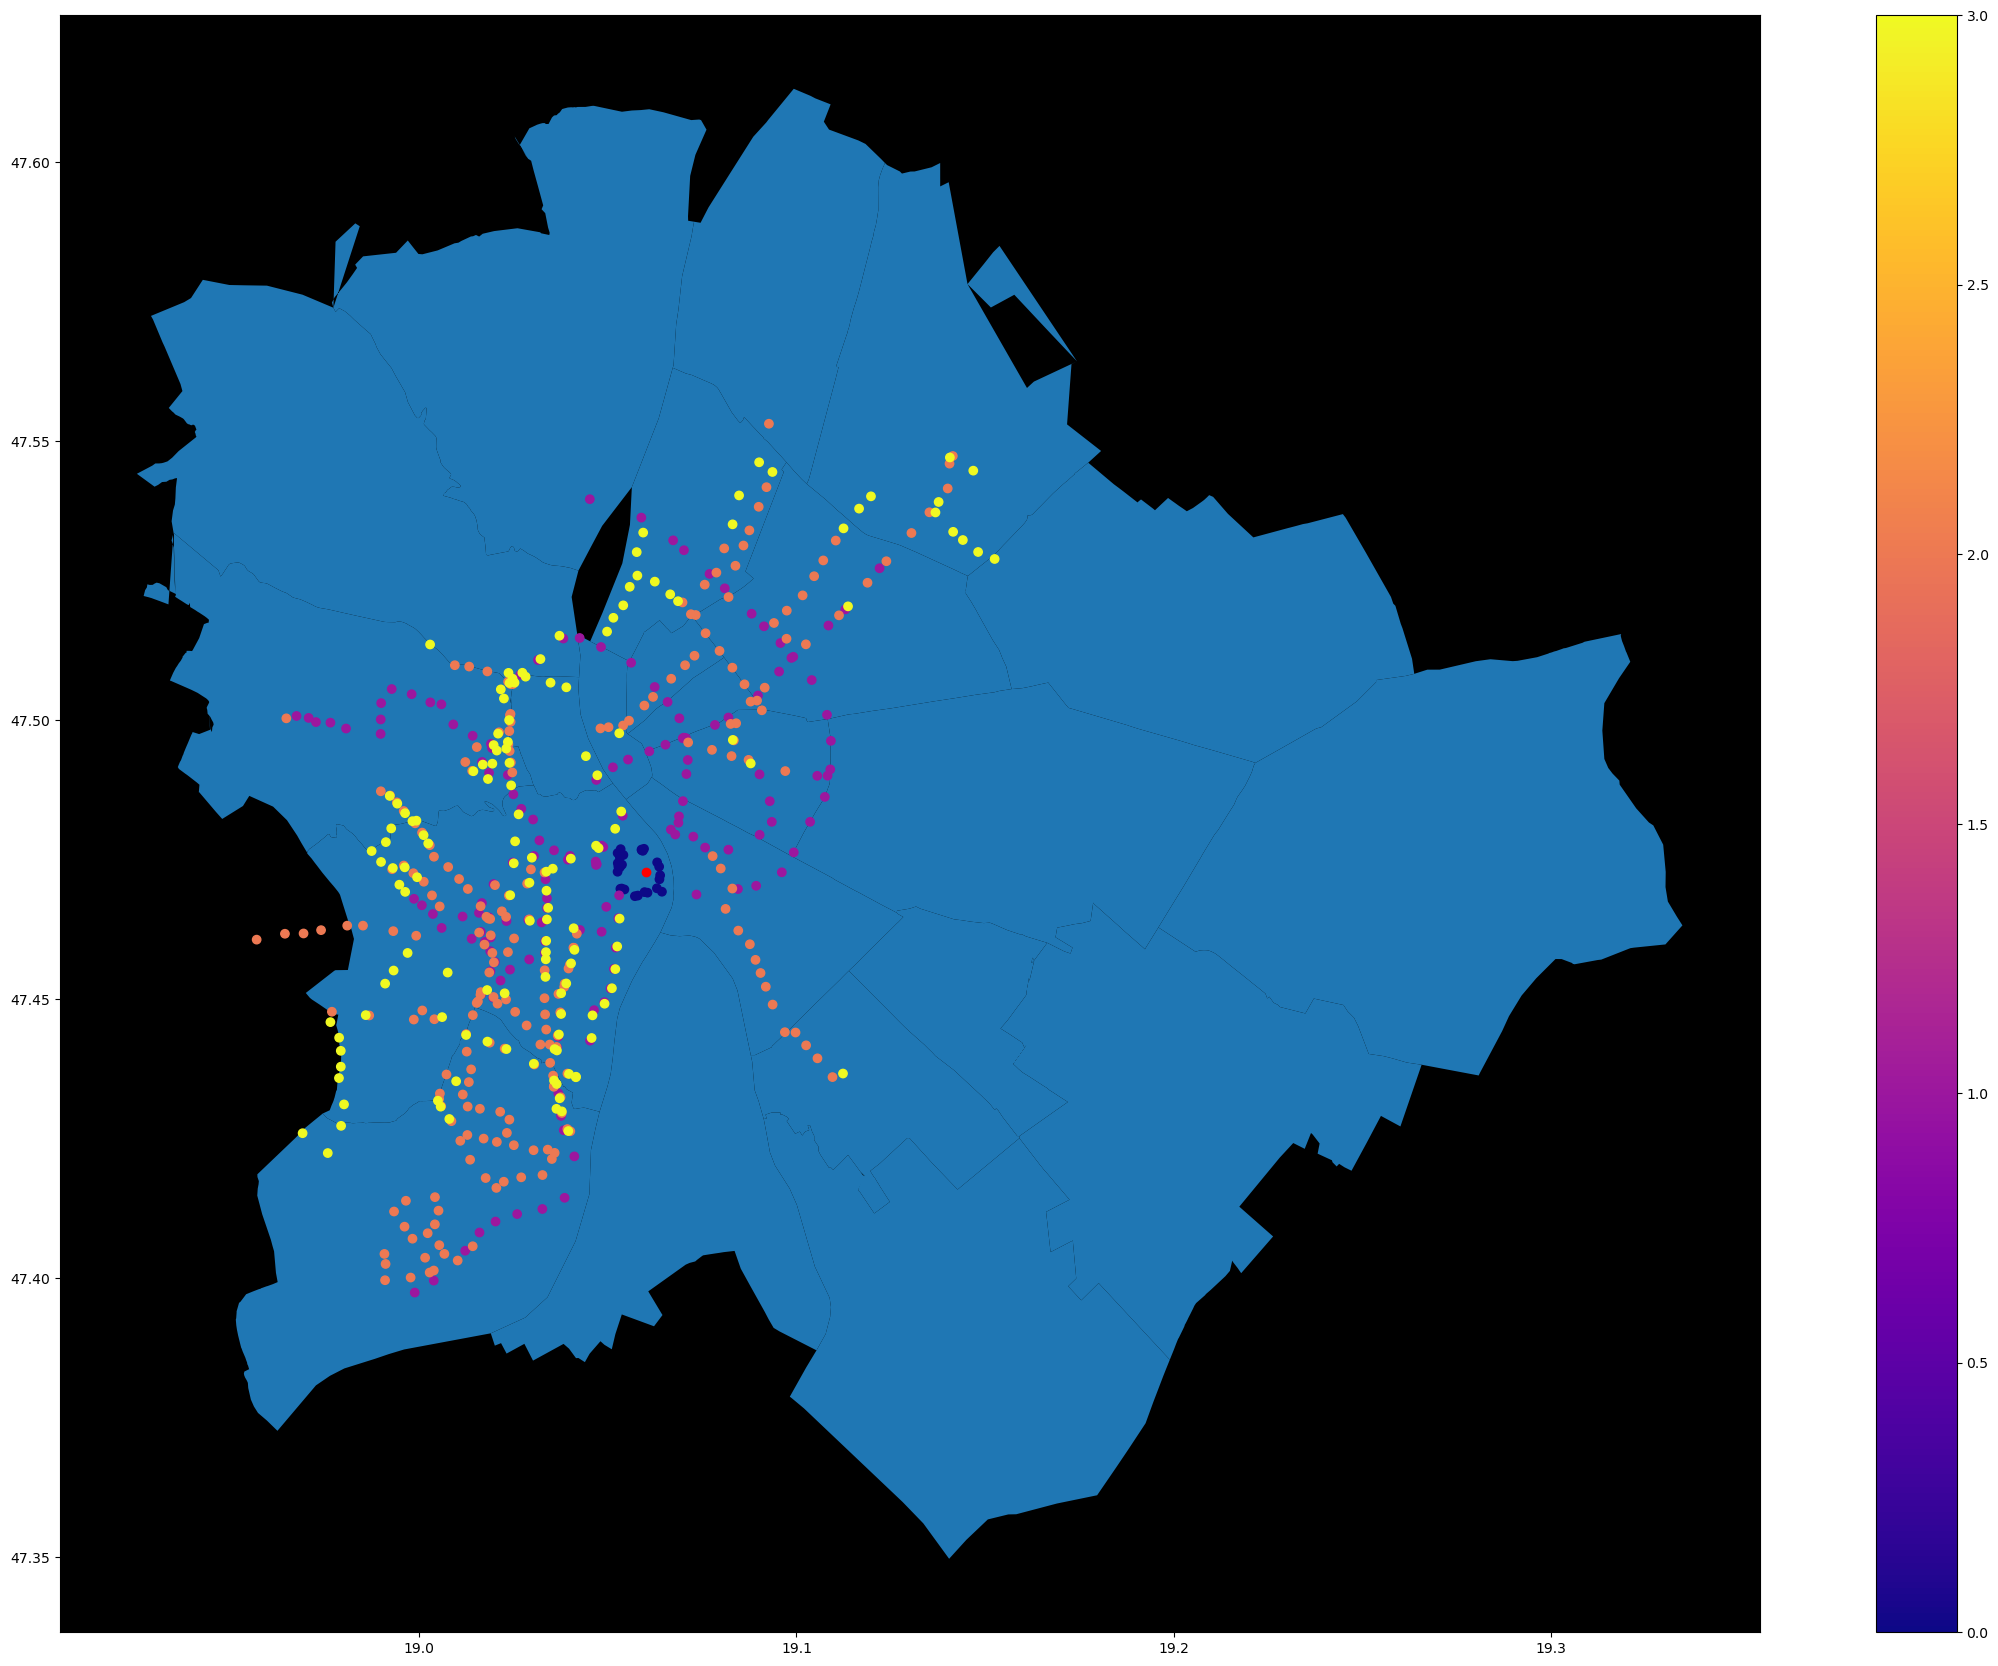

In [34]:
# Set bounding box for Budapest.
def limit_to_bounding_box(gdf, bounding_box):
    return gdf.cx[bounding_box["west"]:bounding_box["east"],bounding_box["south"]:bounding_box["north"]]
bp_bb = {
    "north": 47.6025,
    "south": 47.3962,
    "west": 18.9545,
    "east": 19.2482
}
bp_gdf = limit_to_bounding_box(bp_gdf, bp_bb)
bp_stops = limit_to_bounding_box(final_stops, bp_bb)

# Create figure and plot.
fig = plt.figure(figsize=(30,21))
ax = plt.axes()
ax.set(facecolor = "black")

# Draw districts.
bp_gdf.plot(ax=ax)

# Draw BME I
bme_gdf.to_crs({"init": "EPSG:4326"}, inplace=True)
bme_gdf.plot(ax=ax, color='red')

# Plot stops
bp_stops.plot(ax=ax, cmap="plasma", column='k', legend=True)